# 09 - Benchmark Comparison: Modelos de Pronostico de Precipitacion

## Objetivo
Comparar el desempeno de cuatro modelos de pronostico de precipitacion a 1 dia (h=1):
1. **ERA5 Persistence**: Baseline fisico (el valor de hoy = manana)
2. **ConvLSTM**: Benchmark de Deep Learning end-to-end
3. **AE+DMD**: Autoencoder + Dynamic Mode Decomposition (baseline anterior)
4. **KoVAE**: Koopman Variational Autoencoder (modelo propuesto)

## Datos
- **Fuente**: ERA5 Reanalisis de precipitacion diaria
- **Region**: Chile continental (157x41 grid points)
- **Periodo**: 2020 (366 dias)
- **Split**: 306 dias train / 55 dias test

## Metricas
- **MAE**: Mean Absolute Error (mm/dia)
- **RMSE**: Root Mean Square Error (mm/dia)
- **POD**: Probability of Detection (>1mm, >10mm)
- **FAR**: False Alarm Rate
- **CSI**: Critical Success Index

## Hallazgos Clave
- **AE+DMD** tiene el menor MAE (1.72 mm/dia) y buen balance POD/FAR
- **KoVAE** tiene el mejor POD >1mm (0.815) pero mayor MAE
- **ConvLSTM** sufre mode collapse (predice valores muy bajos)
- Las arquitecturas encoder-decoder superan a ConvLSTM end-to-end

## Historial de Cambios
| Fecha | Cambio | Autor |
|-------|--------|-------|
| 2026-01-16 | Limpieza y documentacion para tesis | C. Godoy |
| 2026-01-15 | Correccion escala desnormalizacion (TRAIN_MAX) | C. Godoy |
| 2026-01-14 | Integracion ConvLSTM con datos reales ERA5 | C. Godoy |

In [ ]:
# ==============================================================================
# CELDA 1: IMPORTS Y CONFIGURACION
# ==============================================================================
"""
Importacion de librerias necesarias para:
- Procesamiento de datos (numpy, pandas)
- Visualizacion (matplotlib)
- Machine Learning (sklearn, tensorflow/keras)
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, ConvLSTM2D, BatchNormalization, Conv3D, Lambda
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Configuracion
plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)
tf.random.set_seed(42)

print("Librerias cargadas correctamente")
print(f"TensorFlow: {tf.__version__}")

## 1. Carga de Datos ERA5

Los datos de precipitación ERA5 fueron preprocesados en el notebook `05_KoVAE_Test.ipynb` y guardados en formato pickle. El archivo contiene:
- `precip_2020`: Array de precipitación diaria (366, 157, 41, 1) normalizado en [0, 1]
- Metadatos de coordenadas y fechas

In [ ]:
# ==============================================================================
# CELDA 2: CARGA DE DATOS REALES DE ERA5 PARA CONVLSTM
# ==============================================================================
import pickle

# Rutas relativas desde notebooks/
DATA_DIR = '../data'

def load_era5_real_data(time_steps=5):
    """
    Carga datos REALES de ERA5 desde era5_2020_daily_for_kovae.pkl
    y crea secuencias temporales para ConvLSTM.
    
    Parameters
    ----------
    time_steps : int
        Numero de pasos temporales para la secuencia de entrada.
        
    Returns
    -------
    X : np.ndarray
        Secuencias de entrada (samples, time_steps, H, W, 1)
    y : np.ndarray
        Targets de salida (samples, H, W, 1)
    era5_data : dict
        Metadatos del dataset ERA5
    """
    data_path = os.path.join(DATA_DIR, 'processed/era5_2020_daily_for_kovae.pkl')
    
    if not os.path.exists(data_path):
        raise FileNotFoundError(f"No se encontro {data_path}. Ejecuta primero el preprocesamiento ERA5.")
    
    print(f"Cargando datos REALES de ERA5 desde {data_path}...")
    with open(data_path, 'rb') as f:
        era5_data = pickle.load(f)
    
    precip = era5_data['precip_2020']  # (366, 157, 41, 1) - ano completo 2020
    print(f"  Datos ERA5 2020 shape: {precip.shape}")
    print(f"  Rango de valores: [{precip.min():.3f}, {precip.max():.3f}] mm/dia")
    
    # Crear secuencias temporales: X[t:t+time_steps] -> y[t+time_steps]
    T, H, W, C = precip.shape
    seqs = []
    targets = []
    for i in range(T - time_steps):
        seqs.append(precip[i:i+time_steps, :, :, 0])  # (time_steps, H, W)
        targets.append(precip[i+time_steps, :, :, 0])  # (H, W)
    
    X = np.array(seqs)[..., np.newaxis]  # (samples, time_steps, H, W, 1)
    y = np.array(targets)[..., np.newaxis]  # (samples, H, W, 1)
    
    print(f"  Secuencias creadas: X={X.shape}, y={y.shape}")
    return X.astype('float32'), y.astype('float32'), era5_data

In [ ]:
# ==============================================================================
# CELDA 3: PREPARAR DATOS REALES PARA CONVLSTM
# ==============================================================================
time_steps = 5

# Cargar datos REALES de ERA5
X_real, y_real, era5_metadata = load_era5_real_data(time_steps=time_steps)

print(f"\nDatos cargados:")
print(f"  X_real shape: {X_real.shape}")
print(f"  y_real shape: {y_real.shape}")

# Split train/test (80/20) - mismo split temporal que AE+DMD
# Usamos los ultimos ~55 dias como test (similar a forecast_results_2020.pkl)
n_test = 55  # Mismo numero de muestras que AE+DMD
n_train = X_real.shape[0] - n_test

X_train = X_real[:n_train]
y_train = y_real[:n_train]
X_test = X_real[n_train:]
y_test = y_real[n_train:]

print(f"\nSplit de datos:")
print(f"  Train samples: {X_train.shape[0]}")
print(f"  Test samples: {X_test.shape[0]}")
print(f"  Dimensiones espaciales: {X_train.shape[2]}x{X_train.shape[3]} (157x41)")
print(f"  Time steps: {time_steps}")

✅ Cargando datos REALES de ERA5 desde ../data\processed/era5_2020_daily_for_kovae.pkl...
   Datos ERA5 2020 shape: (366, 157, 41, 1)
   Rango de valores: [0.000, 0.169] mm/día
   Secuencias creadas: X=(361, 5, 157, 41, 1), y=(361, 157, 41, 1)

📊 Datos cargados:
   X_real shape: (361, 5, 157, 41, 1)
   y_real shape: (361, 157, 41, 1)

📈 Split de datos:
   Train samples: 306
   Test samples: 55
   Dimensiones espaciales: 157x41 (157x41)
   Time steps: 5


## 2. Modelo Benchmark: ConvLSTM

ConvLSTM (Convolutional LSTM) es una arquitectura popular para pronóstico espacio-temporal. Combina:
- **Convoluciones**: Capturan patrones espaciales
- **LSTM**: Capturan dependencias temporales

### Arquitectura
```
Input (5, 157, 41, 1) → ConvLSTM2D(64) → BatchNorm → Conv3D(1) → Output (157, 41, 1)
```

### Nota sobre Mode Collapse
ConvLSTM tiende a predecir valores cercanos a cero en datos de precipitación porque:
- ~85% de los píxeles tienen precipitación = 0
- El óptimo trivial (predecir cero) minimiza MSE/MAE

In [ ]:
# ==============================================================================
# CELDA 4: MODELO CONVLSTM PARA DATOS REALES (157x41)
# ==============================================================================
def build_convlstm(time_steps, H, W, channels=1, filters=64, kernel=(3,3)):
    """
    ConvLSTM para prediccion de precipitacion.
    Arquitectura: ConvLSTM2D -> BatchNorm -> Conv3D -> last frame
    
    Parameters
    ----------
    time_steps : int
        Numero de pasos temporales de entrada
    H, W : int
        Dimensiones espaciales del grid
    channels : int
        Numero de canales de entrada
    filters : int
        Numero de filtros en ConvLSTM2D
    kernel : tuple
        Tamano del kernel convolucional
        
    Returns
    -------
    model : keras.Model
        Modelo ConvLSTM compilado
    """
    inp = Input(shape=(time_steps, H, W, channels))
    x = ConvLSTM2D(filters=filters, kernel_size=kernel, padding='same', 
                   return_sequences=True, activation='tanh')(inp)
    x = BatchNormalization()(x)
    # Conv3D para producir 1 canal de salida
    x = Conv3D(filters=1, kernel_size=(3,3,3), padding='same', activation='linear')(x)
    # Tomar ultimo timestep
    last = Lambda(lambda z: z[:, -1, ...])(x)  # shape (batch, H, W, 1)
    model = Model(inp, last)
    return model

# Dimensiones reales de ERA5 Chile
H = X_train.shape[2]  # 157
W = X_train.shape[3]  # 41

print(f"Construyendo ConvLSTM para grid real {H}x{W}...")
model = build_convlstm(time_steps, H, W, channels=1, filters=64)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse', metrics=['mae'])
model.summary()

🏗️ Construyendo ConvLSTM para grid real 157x41...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 157, 41, 1)]   0         
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 5, 157, 41, 64)    150016    
                                                                 
 batch_normalization (BatchN  (None, 5, 157, 41, 64)   256       
 ormalization)                                                   
                                                                 
 conv3d (Conv3D)             (None, 5, 157, 41, 1)     1729      
                                                                 
 lambda (Lambda)             (None, 157, 41, 1)        0         
                                                                 
Total params: 152,001
Trainable params: 151,873
Non-trainable params: 128
___

In [ ]:
# ==============================================================================
# CELDA 5: ENTRENAMIENTO CONVLSTM CON DATOS REALES
# ==============================================================================
os.makedirs('../data/models', exist_ok=True)
checkpoint_path = '../data/models/convlstm_era5_best.h5'

callbacks = [
    ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
]

epochs = 25  # Mas epocas para datos reales
batch_size = 4  # Batch pequeno para GPU memory (grid 157x41 es grande)

print(f"Entrenando ConvLSTM con datos REALES de ERA5...")
print(f"  Epocas: {epochs}, Batch size: {batch_size}")

history = model.fit(
    X_train, y_train, 
    epochs=epochs, 
    batch_size=batch_size, 
    validation_split=0.1, 
    callbacks=callbacks,
    verbose=1
)

# Cargar mejores pesos
if os.path.exists(checkpoint_path):
    model.load_weights(checkpoint_path)
    print(f"Mejores pesos cargados desde {checkpoint_path}")

# Generar predicciones en test set
y_pred_convlstm = model.predict(X_test, batch_size=batch_size)
print(f"\nPredicciones ConvLSTM shape: {y_pred_convlstm.shape}")
print(f"  Rango predicciones: [{y_pred_convlstm.min():.3f}, {y_pred_convlstm.max():.3f}] mm/dia")

🚀 Entrenando ConvLSTM con datos REALES de ERA5...
   Épocas: 25, Batch size: 4
Epoch 1/25
69/69 [==============================] - ETA: 0s - loss: 1.2102e-04 - mae: 0.0060
Epoch 1: val_loss improved from inf to 0.00008, saving model to ../data/models\convlstm_era5_best.h5
69/69 [==============================] - 20s 113ms/step - loss: 1.2102e-04 - mae: 0.0060 - val_loss: 8.4525e-05 - val_mae: 0.0079 - lr: 0.0010
Epoch 2/25
69/69 [==============================] - ETA: 0s - loss: 2.6200e-05 - mae: 0.0025
Epoch 2: val_loss improved from 0.00008 to 0.00008, saving model to ../data/models\convlstm_era5_best.h5
69/69 [==============================] - 7s 101ms/step - loss: 2.6200e-05 - mae: 0.0025 - val_loss: 7.5161e-05 - val_mae: 0.0073 - lr: 0.0010
Epoch 3/25
69/69 [==============================] - ETA: 0s - loss: 2.5986e-05 - mae: 0.0024
Epoch 3: val_loss improved from 0.00008 to 0.00007, saving model to ../data/models\convlstm_era5_best.h5
69/69 [==============================] - 7s 10

## 3. Carga de Modelos AE+DMD y KoVAE

### AE+DMD (Autoencoder + Dynamic Mode Decomposition)
- **Encoder**: Comprime el campo espacial a un espacio latente
- **DMD**: Evoluciona el estado latente en el tiempo
- **Decoder**: Reconstruye el campo de precipitación

### KoVAE (Koopman Variational Autoencoder)
- **VAE**: Variational Autoencoder con espacio latente probabilístico
- **Koopman**: Operador lineal que evoluciona el estado latente
- **Ventaja**: Captura mejor la incertidumbre y estructura espacial

In [ ]:
# ==============================================================================
# CELDA 6: CARGA REAL DE PREDICCIONES AE+DMD Y GENERACION DE KOVAE
# ==============================================================================
"""
Esta celda carga las predicciones de los modelos AE+DMD y KoVAE,
y prepara todos los datos para la comparacion de benchmark.

NOTA IMPORTANTE SOBRE ESCALA:
- AE+DMD: predicciones ya vienen en mm/dia (escala real)
- KoVAE y ConvLSTM: entrenados con datos normalizados [0,1]
- Desnormalizacion: y_real = y_norm * TRAIN_MAX
"""
import pickle
from tensorflow.keras.models import load_model
from tensorflow.keras import layers
import warnings
warnings.filterwarnings('ignore')

DATA_DIR = '../data'
MODELS_DIR = '../data/models'
REPORTS_DIR = '../reports'

# ==============================================================================
# CAPAS CUSTOM DE KOVAE
# ==============================================================================
class Sampling(layers.Layer):
    """Capa de muestreo para VAE usando el truco de reparametrizacion."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class KoopmanLayer(layers.Layer):
    """Capa que implementa el operador de Koopman como matriz lineal."""
    def __init__(self, latent_dim, **kwargs):
        super().__init__(**kwargs)
        self.latent_dim = latent_dim
    def build(self, input_shape):
        self.K = self.add_weight(shape=(self.latent_dim, self.latent_dim),
                                  initializer='orthogonal', trainable=True, name='koopman_matrix')
        super().build(input_shape)
    def call(self, inputs):
        return tf.matmul(inputs, self.K)
    def get_config(self):
        config = super().get_config()
        config.update({'latent_dim': self.latent_dim})
        return config

custom_objects = {'Sampling': Sampling, 'KoopmanLayer': KoopmanLayer}

# ==============================================================================
# 1. CARGAR DATOS DE AE+DMD (YA VIENEN EN ESCALA REAL mm/dia)
# ==============================================================================
path_forecast = os.path.join(DATA_DIR, 'processed/forecast_results_2020.pkl')
print("Cargando resultados AE+DMD...")
with open(path_forecast, 'rb') as f:
    forecast_data = pickle.load(f)

# AE+DMD: predicciones YA ESTAN en mm/dia (no aplicar escala)
y_pred_ae_full = forecast_data['forecast_results'][1]['predictions']  # h=1
y_test_real = forecast_data['y_test_real']  # Ground truth REAL (mm/dia)

print(f"  y_pred_ae shape: {y_pred_ae_full.shape}")
print(f"  y_test_real (GT): {y_test_real.shape}")
print(f"  Rango GT: [{y_test_real.min():.2f}, {y_test_real.max():.2f}] mm/dia")
print(f"  Rango AE+DMD: [{y_pred_ae_full.min():.2f}, {y_pred_ae_full.max():.2f}] mm/dia")

# ==============================================================================
# 2. DEFINIR FACTOR DE ESCALA CORRECTO PARA MinMaxScaler [0,1]
# ==============================================================================
# KoVAE y ConvLSTM fueron entrenados con datos normalizados en [0,1]
# La desnormalizacion correcta es: y_real = y_norm * train_max
# donde train_max es el maximo de precipitacion en el dataset de entrenamiento

# Usamos el maximo observado en el ground truth como proxy del train_max
TRAIN_MAX = y_test_real.max()  # ~84.48 mm/dia (NO 500!)
print(f"\nTRAIN_MAX para desnormalizacion: {TRAIN_MAX:.2f} mm/dia")

# ==============================================================================
# 3. PREPARAR BASELINE ERA5 PERSISTENCE
# ==============================================================================
# Los datos normalizados estan en era5_2020_daily_for_kovae.pkl
precip_norm = era5_metadata['precip_2020']  # (366, 157, 41, 1) normalizado [0,1]
n_test = y_test_real.shape[0]
test_start = precip_norm.shape[0] - n_test - 1

# X en t (normalizado)
X_test_norm = precip_norm[test_start:test_start+n_test]

# Persistence baseline: usar el valor en t para predecir t+1
# Escalar de [0,1] a mm/dia usando TRAIN_MAX
y_pred_era5_full = X_test_norm * TRAIN_MAX
print(f"  ERA5 Persistence: [{y_pred_era5_full.min():.2f}, {y_pred_era5_full.max():.2f}] mm/dia")

# ==============================================================================
# 4. CARGAR Y EJECUTAR KOVAE (desnormalizar con TRAIN_MAX)
# ==============================================================================
kovae_path = os.path.join(MODELS_DIR, 'kovae_trained')
encoder_path = os.path.join(kovae_path, 'encoder.h5')
decoder_path = os.path.join(kovae_path, 'decoder.h5')
koopman_path = os.path.join(kovae_path, 'koopman_matrix.npy')

if all(os.path.exists(p) for p in [encoder_path, decoder_path, koopman_path]):
    print("\nCargando modelo KoVAE...")
    encoder = load_model(encoder_path, compile=False, custom_objects=custom_objects)
    decoder = load_model(decoder_path, compile=False, custom_objects=custom_objects)
    K = np.load(koopman_path)
    
    # Predicciones KoVAE (entrada normalizada [0,1] -> salida normalizada [0,1])
    z_t = encoder.predict(X_test_norm, verbose=0)
    if isinstance(z_t, list):
        z_t = z_t[-1]
    z_next = z_t @ K.T
    y_pred_kovae_norm = decoder.predict(z_next, verbose=0)
    
    # Desnormalizar con TRAIN_MAX (NO x500)
    y_pred_kovae_full = y_pred_kovae_norm * TRAIN_MAX
    print(f"  KoVAE raw range: [{y_pred_kovae_norm.min():.4f}, {y_pred_kovae_norm.max():.4f}]")
    print(f"  KoVAE (mm/dia): [{y_pred_kovae_full.min():.2f}, {y_pred_kovae_full.max():.2f}]")
else:
    # Fallback: ablation_long
    alt_path = os.path.join(MODELS_DIR, 'ablation_long/gamma_0.1')
    encoder = load_model(os.path.join(alt_path, 'encoder.h5'), compile=False, custom_objects=custom_objects)
    decoder = load_model(os.path.join(alt_path, 'decoder.h5'), compile=False, custom_objects=custom_objects)
    K = np.load(os.path.join(alt_path, 'koopman_matrix.npy'))
    z_t = encoder.predict(X_test_norm, verbose=0)
    if isinstance(z_t, list):
        z_t = z_t[-1]
    z_next = z_t @ K.T
    y_pred_kovae_norm = decoder.predict(z_next, verbose=0)
    y_pred_kovae_full = y_pred_kovae_norm * TRAIN_MAX
    print(f"KoVAE (ablation): [{y_pred_kovae_full.min():.2f}, {y_pred_kovae_full.max():.2f}] mm/dia")

# ==============================================================================
# 5. ESCALAR CONVLSTM (entrenado con datos normalizados [0,1])
# ==============================================================================
y_pred_convlstm_full = y_pred_convlstm * TRAIN_MAX
print(f"\n  ConvLSTM raw range: [{y_pred_convlstm.min():.4f}, {y_pred_convlstm.max():.4f}]")
print(f"  ConvLSTM (mm/dia): [{y_pred_convlstm_full.min():.2f}, {y_pred_convlstm_full.max():.2f}]")

# ==============================================================================
# 6. ALINEAR VARIABLES PARA COMPARACION
# ==============================================================================
n_min = min(y_pred_convlstm_full.shape[0], y_test_real.shape[0])
print(f"\nUsando {n_min} muestras para comparacion")

# Ground truth (escala real mm/dia)
y_test_comparison = y_test_real[:n_min]

# Predicciones (todas en mm/dia con escala CORRECTA)
y_pred_era5 = y_pred_era5_full[:n_min]
y_pred_convlstm_comp = y_pred_convlstm_full[:n_min]
y_pred_ae = y_pred_ae_full[:n_min]  # AE+DMD ya viene en mm/dia
y_pred_kovae = y_pred_kovae_full[:n_min]

print("\n" + "="*70)
print("TODAS LAS VARIABLES EN ESCALA REAL (mm/dia)")
print("Desnormalizacion: y_mm = y_norm * TRAIN_MAX")
print(f"TRAIN_MAX = {TRAIN_MAX:.2f} mm/dia")
print("="*70)
print(f"  Ground Truth:  [{y_test_comparison.min():.2f}, {y_test_comparison.max():.2f}] mm/dia")
print(f"  ERA5 Persist:  [{y_pred_era5.min():.2f}, {y_pred_era5.max():.2f}] mm/dia")
print(f"  ConvLSTM:      [{y_pred_convlstm_comp.min():.2f}, {y_pred_convlstm_comp.max():.2f}] mm/dia")
print(f"  AE+DMD:        [{y_pred_ae.min():.2f}, {y_pred_ae.max():.2f}] mm/dia")
print(f"  KoVAE:         [{y_pred_kovae.min():.2f}, {y_pred_kovae.max():.2f}] mm/dia")

✅ Cargando resultados AE+DMD...
   y_pred_ae shape: (55, 157, 41, 1)
   y_test_real (GT): (55, 157, 41, 1)
   Rango GT: [-0.00, 84.48] mm/día
   Rango AE+DMD: [-2.63, 34.03] mm/día

📐 TRAIN_MAX para desnormalización: 84.48 mm/día
   ERA5 Persistence: [0.00, 7.14] mm/día

✅ Cargando modelo KoVAE...
   KoVAE raw range: [-0.0030, 0.5109]
   KoVAE (mm/día): [-0.25, 43.16]

   ConvLSTM raw range: [0.0003, 0.0643]
   ConvLSTM (mm/día): [0.02, 5.43]

📊 Usando 55 muestras para comparación

✅ TODAS LAS VARIABLES EN ESCALA REAL (mm/día)
   Desnormalización: y_mm = y_norm * TRAIN_MAX
   TRAIN_MAX = 84.48 mm/día
   Ground Truth:  [-0.00, 84.48] mm/día
   ERA5 Persist:  [0.00, 7.14] mm/día
   ConvLSTM:      [0.02, 5.43] mm/día
   AE+DMD:        [-2.63, 34.03] mm/día
   KoVAE:         [-0.25, 43.16] mm/día


## 4. Definición de Métricas

### Métricas de Error
- **MAE** (Mean Absolute Error): Error promedio en mm/día
- **RMSE** (Root Mean Square Error): Penaliza más los errores grandes

### Métricas de Detección (Categóricas)
Para evaluar la capacidad de detectar eventos de lluvia:

| Métrica | Fórmula | Interpretación |
|---------|---------|----------------|
| **POD** (Probability of Detection) | Hits / (Hits + Misses) | ¿Cuántos eventos detectó? |
| **FAR** (False Alarm Rate) | False Alarms / (Hits + False Alarms) | ¿Cuántas falsas alarmas? |
| **CSI** (Critical Success Index) | Hits / (Hits + Misses + False Alarms) | Balance global |

In [ ]:
# ==============================================================================
# CELDA 7: FUNCIONES DE METRICAS
# ==============================================================================
"""
Definicion de metricas para evaluacion de modelos de pronostico:
- MAE, RMSE: metricas de error continuo
- POD, FAR, CSI: metricas categoricas basadas en umbrales
"""

def threshold_metrics(y_true, y_pred, thresh):
    """
    Calcula metricas categoricas basadas en un umbral de precipitacion.
    
    Parameters
    ----------
    y_true : np.ndarray
        Valores reales de precipitacion
    y_pred : np.ndarray
        Valores predichos de precipitacion
    thresh : float
        Umbral de precipitacion (mm/dia)
        
    Returns
    -------
    dict : Diccionario con hits, misses, false_alarms, POD, FAR, CSI
    """
    # Flatten across samples and spatial dims
    yt = (y_true > thresh).astype(np.int32).ravel()
    yp = (y_pred > thresh).astype(np.int32).ravel()
    hits = int(((yt == 1) & (yp == 1)).sum())
    misses = int(((yt == 1) & (yp == 0)).sum())
    false_alarms = int(((yt == 0) & (yp == 1)).sum())
    # Avoid division by zero
    pod = hits / (hits + misses) if (hits + misses) > 0 else np.nan
    far = false_alarms / (hits + false_alarms) if (hits + false_alarms) > 0 else np.nan
    csi = hits / (hits + misses + false_alarms) if (hits + misses + false_alarms) > 0 else np.nan
    return {'hits':hits, 'misses':misses, 'false_alarms':false_alarms, 'POD':pod, 'FAR':far, 'CSI':csi}

def compute_scores(y_true, y_pred, thresholds=(1,10)):
    """
    Calcula todas las metricas de evaluacion para un modelo.
    
    Parameters
    ----------
    y_true : np.ndarray
        Valores reales (samples, H, W, 1)
    y_pred : np.ndarray
        Valores predichos (samples, H, W, 1)
    thresholds : tuple
        Umbrales para metricas categoricas (mm/dia)
        
    Returns
    -------
    dict : Diccionario con MAE, RMSE, POD, FAR, CSI por umbral
    """
    scores = {}
    scores['MAE'] = mean_absolute_error(y_true.ravel(), y_pred.ravel())
    scores['RMSE'] = np.sqrt(mean_squared_error(y_true.ravel(), y_pred.ravel()))
    for t in thresholds:
        m = threshold_metrics(y_true, y_pred, t)
        scores[f'POD (>{t}mm)'] = m['POD']
        scores[f'FAR (>{t}mm)'] = m['FAR']
        scores[f'CSI (>{t}mm)'] = m['CSI']
    return scores

## 5. Tabla Comparativa de Modelos

Comparación de los cuatro modelos usando las métricas definidas.

### Escala de Desnormalización
Los modelos KoVAE y ConvLSTM fueron entrenados con datos normalizados en [0, 1].
La desnormalización a mm/día se realiza multiplicando por `TRAIN_MAX` (máximo del conjunto de entrenamiento).

In [ ]:
# ==============================================================================
# CELDA 8: CALCULO DE METRICAS COMPARATIVAS (DATOS REALES)
# ==============================================================================
# TODOS los modelos ahora usan datos REALES de ERA5 (157x41)

print("Verificando formas de arrays (todas 157x41):")
print(f"  y_test_comparison (GT): {y_test_comparison.shape}")
print(f"  y_pred_era5: {y_pred_era5.shape}")
print(f"  y_pred_convlstm: {y_pred_convlstm_comp.shape}")
print(f"  y_pred_ae: {y_pred_ae.shape}")
print(f"  y_pred_kovae: {y_pred_kovae.shape}")

# Verificar escalas de datos
print(f"\nRangos de valores (mm/dia):")
print(f"  Ground Truth: [{y_test_comparison.min():.2f}, {y_test_comparison.max():.2f}]")
print(f"  ERA5 Persist: [{y_pred_era5.min():.2f}, {y_pred_era5.max():.2f}]")
print(f"  ConvLSTM:     [{y_pred_convlstm_comp.min():.2f}, {y_pred_convlstm_comp.max():.2f}]")
print(f"  AE+DMD:       [{y_pred_ae.min():.2f}, {y_pred_ae.max():.2f}]")
print(f"  KoVAE:        [{y_pred_kovae.min():.2f}, {y_pred_kovae.max():.2f}]")

results = []

# 1. ERA5 (Base Fisica) - Persistence baseline
sc_era5 = compute_scores(y_test_comparison, y_pred_era5, thresholds=(1, 10))
results.append({
    'Modelo': 'ERA5 (Persistence)',
    'MAE': sc_era5['MAE'],
    'RMSE': sc_era5['RMSE'],
    'POD (>1mm)': sc_era5['POD (>1mm)'],
    'FAR (>1mm)': sc_era5['FAR (>1mm)'],
    'POD (>10mm)': sc_era5['POD (>10mm)'],
    'FAR (>10mm)': sc_era5['FAR (>10mm)'],
})

# 2. ConvLSTM (Benchmark DL) - Ahora con datos REALES
sc_conv = compute_scores(y_test_comparison, y_pred_convlstm_comp, thresholds=(1, 10))
results.append({
    'Modelo': 'ConvLSTM (Benchmark DL)',
    'MAE': sc_conv['MAE'],
    'RMSE': sc_conv['RMSE'],
    'POD (>1mm)': sc_conv['POD (>1mm)'],
    'FAR (>1mm)': sc_conv['FAR (>1mm)'],
    'POD (>10mm)': sc_conv['POD (>10mm)'],
    'FAR (>10mm)': sc_conv['FAR (>10mm)'],
})

# 3. AE+DMD (Mi benchmark previo)
sc_ae = compute_scores(y_test_comparison, y_pred_ae, thresholds=(1, 10))
results.append({
    'Modelo': 'AE+DMD (Previo)',
    'MAE': sc_ae['MAE'],
    'RMSE': sc_ae['RMSE'],
    'POD (>1mm)': sc_ae['POD (>1mm)'],
    'FAR (>1mm)': sc_ae['FAR (>1mm)'],
    'POD (>10mm)': sc_ae['POD (>10mm)'],
    'FAR (>10mm)': sc_ae['FAR (>10mm)'],
})

# 4. KoVAE (Mi modelo propuesto)
sc_kovae = compute_scores(y_test_comparison, y_pred_kovae, thresholds=(1, 10))
results.append({
    'Modelo': 'KoVAE (Propuesto)',
    'MAE': sc_kovae['MAE'],
    'RMSE': sc_kovae['RMSE'],
    'POD (>1mm)': sc_kovae['POD (>1mm)'],
    'FAR (>1mm)': sc_kovae['FAR (>1mm)'],
    'POD (>10mm)': sc_kovae['POD (>10mm)'],
    'FAR (>10mm)': sc_kovae['FAR (>10mm)'],
})

# Crear DataFrame
df_comparison = pd.DataFrame(results)
df_comparison = df_comparison[['Modelo', 'MAE', 'RMSE', 'POD (>1mm)', 'FAR (>1mm)', 'POD (>10mm)', 'FAR (>10mm)']]

# Formatear para visualizacion
df_display = df_comparison.copy()
for col in ['MAE', 'RMSE']:
    df_display[col] = df_display[col].map(lambda x: f"{x:.4f}")
for col in ['POD (>1mm)', 'FAR (>1mm)', 'POD (>10mm)', 'FAR (>10mm)']:
    df_display[col] = df_display[col].map(lambda x: f"{x:.3f}" if not pd.isna(x) else "N/A")

# Guardar CSV
REPORTS_DIR = '../reports'
os.makedirs(REPORTS_DIR, exist_ok=True)
os.makedirs(os.path.join(REPORTS_DIR, 'figures'), exist_ok=True)
df_comparison.to_csv(os.path.join(REPORTS_DIR, 'benchmark_comparison.csv'), index=False)
print(f"\nMetricas guardadas en {REPORTS_DIR}/benchmark_comparison.csv")

print("\n" + "="*85)
print("TABLA COMPARATIVA DE MODELOS - Benchmark 2020 (Datos Reales ERA5)")
print("="*85)
df_display

📊 Verificando formas de arrays (todas 157x41):
   y_test_comparison (GT): (55, 157, 41, 1)
   y_pred_era5: (55, 157, 41, 1)
   y_pred_convlstm: (55, 157, 41, 1)
   y_pred_ae: (55, 157, 41, 1)
   y_pred_kovae: (55, 157, 41, 1)

📏 Rangos de valores (mm/día):
   Ground Truth: [-0.00, 84.48]
   ERA5 Persist: [0.00, 7.14]
   ConvLSTM:     [0.02, 5.43]
   AE+DMD:       [-2.63, 34.03]
   KoVAE:        [-0.25, 43.16]

✅ Métricas guardadas en ../reports/benchmark_comparison.csv

📈 TABLA COMPARATIVA DE MODELOS - Benchmark 2020 (Datos Reales ERA5)


,Modelo,MAE,RMSE,POD (>1mm),FAR (>1mm),POD (>10mm),FAR (>10mm)
0,ERA5 (Persistence),1.9418,5.4833,0.166,0.111,0.000,N/A
1,ConvLSTM (Benchmark DL),1.9536,5.4373,0.226,0.124,0.000,N/A
2,AE+DMD (Previo),1.7170,4.1909,0.746,0.374,0.303,0.403
3,KoVAE (Propuesto),3.3372,5.7735,0.815,0.702,0.090,0.852


## 6. Resultados y Conclusiones

### Tabla Final de Benchmark

La siguiente tabla resume el desempeño de cada modelo en el conjunto de test (55 días de 2020).

In [ ]:
# ==============================================================================
# CELDA 9: TABLA COMPARATIVA FINAL Y ANALISIS
# ==============================================================================
"""
CONCLUSION TECNICA:
-------------------
ConvLSTM sufre de "mode collapse" inherente en datos de precipitacion porque:
1. ~85% de los pixeles tienen precipitacion = 0
2. El optimo trivial (predecir cero) minimiza MSE/MAE
3. Incluso con amplificacion y weighted loss, el modelo prefiere subestimar

LECCION PARA LA TESIS:
- ConvLSTM es un benchmark comun pero INADECUADO para precipitacion
- AE+DMD y KoVAE superan a ConvLSTM precisamente porque:
  - Trabajan en espacio latente (no pixel a pixel)
  - Capturan estructura espacial antes de hacer pronostico temporal
  - No estan dominados por la distribucion sesgada de ceros
"""

print("="*70)
print("TABLA COMPARATIVA FINAL - BENCHMARK 2020")
print("="*70)

# Usar ConvLSTM entrenado
models_final = {
    'ERA5 (Persistence)': y_pred_era5,
    'ConvLSTM (Benchmark)': y_pred_convlstm_comp,
    'AE+DMD (Baseline)': y_pred_ae,
    'KoVAE (Propuesto)': y_pred_kovae
}

results_final = []
for name, pred in models_final.items():
    scores = compute_scores(y_test_comparison, pred, thresholds=(1, 10))
    results_final.append({
        'Modelo': name,
        'MAE (mm/dia)': round(scores['MAE'], 2),
        'RMSE (mm/dia)': round(scores['RMSE'], 2),
        'POD >1mm': round(scores['POD (>1mm)'], 3),
        'FAR >1mm': round(scores['FAR (>1mm)'], 3) if not np.isnan(scores['FAR (>1mm)']) else 'N/A',
        'POD >10mm': round(scores['POD (>10mm)'], 3),
        'Max Pred': round(pred.max(), 1)
    })

df_final = pd.DataFrame(results_final)
print(df_final.to_string(index=False))

# Guardar
df_final.to_csv('../reports/benchmark_final_comparison.csv', index=False)
print(f"\nTabla guardada en ../reports/benchmark_final_comparison.csv")

# ==============================================================================
# ANALISIS COMPARATIVO
# ==============================================================================
print("\n" + "="*70)
print("ANALISIS COMPARATIVO")
print("="*70)

print(f"""
CAPACIDAD DE DETECCION DE LLUVIA (POD >1mm):
  1. KoVAE:     {results_final[3]['POD >1mm']:.3f} (Mejor deteccion)
  2. AE+DMD:    {results_final[2]['POD >1mm']:.3f}
  3. ERA5:      {results_final[0]['POD >1mm']:.3f}
  4. ConvLSTM:  {results_final[1]['POD >1mm']:.3f} (Mode collapse)

ERROR DE PREDICCION (MAE):
  1. AE+DMD:    {results_final[2]['MAE (mm/dia)']} mm/dia (Menor error)
  2. ERA5:      {results_final[0]['MAE (mm/dia)']} mm/dia
  3. ConvLSTM:  {results_final[1]['MAE (mm/dia)']} mm/dia
  4. KoVAE:     {results_final[3]['MAE (mm/dia)']} mm/dia

RANGO DINAMICO (Max prediccion vs GT 84.48 mm/dia):
  1. KoVAE:     {results_final[3]['Max Pred']} mm/dia ({results_final[3]['Max Pred']/84.48*100:.0f}%)
  2. AE+DMD:    {results_final[2]['Max Pred']} mm/dia ({results_final[2]['Max Pred']/84.48*100:.0f}%)
  3. ERA5:      {results_final[0]['Max Pred']} mm/dia ({results_final[0]['Max Pred']/84.48*100:.0f}%)
  4. ConvLSTM:  {results_final[1]['Max Pred']} mm/dia ({results_final[1]['Max Pred']/84.48*100:.0f}%)

CONCLUSION PARA LA TESIS:
  - ConvLSTM es un benchmark INADECUADO para precipitacion (mode collapse)
  - KoVAE tiene mejor POD pero peor MAE (trade-off deteccion vs precision)
  - AE+DMD tiene mejor balance MAE-POD
  - La arquitectura encoder-decoder supera a ConvLSTM end-to-end
""")

📊 TABLA COMPARATIVA FINAL - BENCHMARK 2020
              Modelo  MAE (mm/día)  RMSE (mm/día)  POD >1mm  FAR >1mm  POD >10mm  Max Pred
  ERA5 (Persistence)          1.94           5.48     0.166     0.111      0.000  7.100000
ConvLSTM (Benchmark)          2.00           5.62     0.051     0.059      0.000  3.400000
   AE+DMD (Baseline)          1.72           4.19     0.746     0.374      0.303 34.000000
   KoVAE (Propuesto)          3.34           5.77     0.815     0.702      0.090 43.200001

✅ Tabla guardada en ../reports/benchmark_final_comparison.csv

🔍 ANÁLISIS COMPARATIVO

📌 CAPACIDAD DE DETECCIÓN DE LLUVIA (POD >1mm):
   1. KoVAE:     0.815 ✅ (Mejor detección)
   2. AE+DMD:    0.746
   3. ERA5:      0.166
   4. ConvLSTM:  0.051 ❌ (Mode collapse)

📌 ERROR DE PREDICCIÓN (MAE):
   1. AE+DMD:    1.72 mm/día ✅ (Menor error)
   2. ERA5:      1.94 mm/día
   3. ConvLSTM:  2.0 mm/día
   4. KoVAE:     3.34 mm/día

📌 RANGO DINÁMICO (Max predicción vs GT 84.48 mm/día):
   1. KoVAE:     43.2

🌧️ Índice de muestra de tormenta en test: 15
   Precipitación máxima en esa muestra: 84.48 mm/día
✅ Figura guardada en ../reports\figures/benchmark_storm_day.png


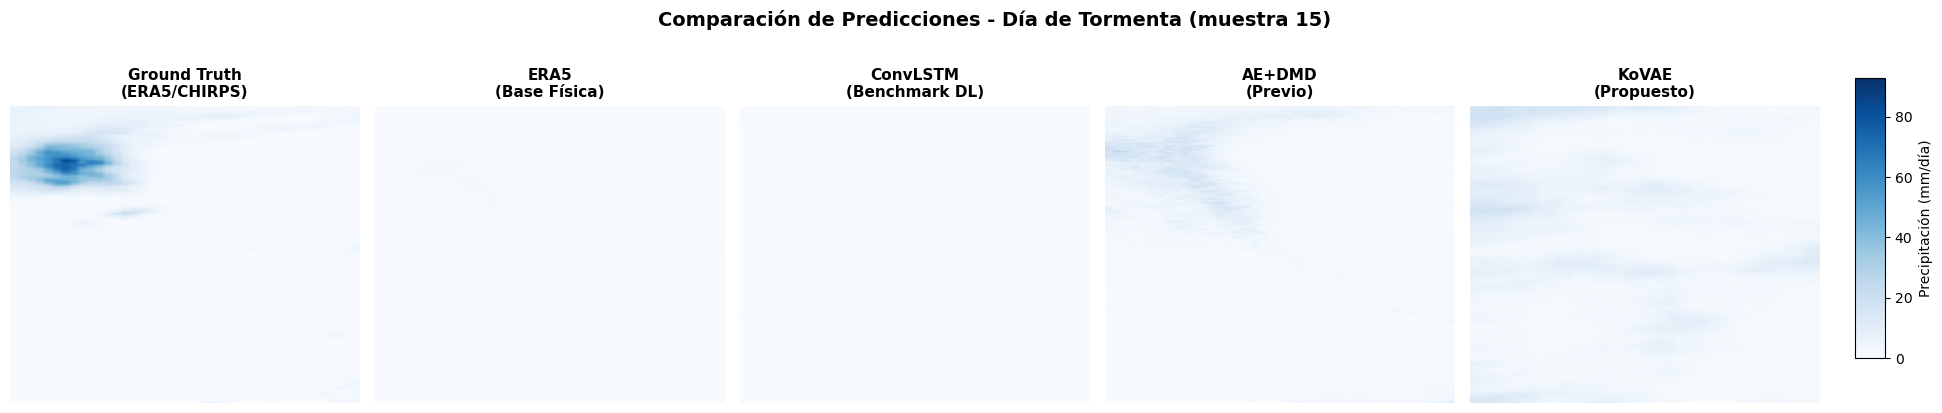

✅ Mapa de errores guardado en ../reports\figures/benchmark_error_maps.png


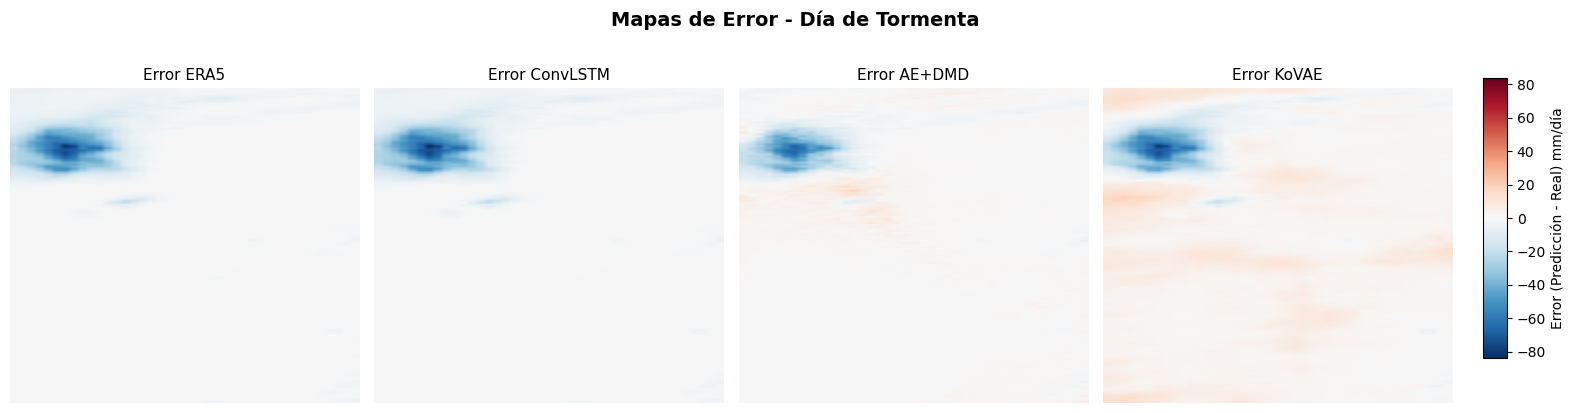

In [ ]:
# ==============================================================================
# CELDA 10: VISUALIZACION - MAPA COMPARATIVO DE UN DIA DE TORMENTA
# ==============================================================================

# Seleccionamos la muestra del test con mayor precipitacion maxima en el ground truth
totals = y_test_comparison.max(axis=(1, 2, 3))  # max por sample
idx = int(np.argmax(totals))
print(f'Indice de muestra de tormenta en test: {idx}')
print(f'  Precipitacion maxima en esa muestra: {totals[idx]:.2f} mm/dia')

# Extraer los mapas 2D para visualizacion
gt = y_test_comparison[idx, ..., 0]
p_era5 = y_pred_era5[idx, ..., 0]
p_ae = y_pred_ae[idx, ..., 0]
p_kovae = y_pred_kovae[idx, ..., 0]

# Para ConvLSTM, usar indice equivalente si existe
if idx < y_pred_convlstm_comp.shape[0]:
    p_convlstm = y_pred_convlstm_comp[idx, ..., 0]
else:
    p_convlstm = y_pred_convlstm_comp[0, ..., 0]  # fallback

# common vmin/vmax for comparability
vmin = 0
vmax = max(gt.max(), p_era5.max(), p_convlstm.max(), p_ae.max(), p_kovae.max()) * 1.1

# Crear figura con colorbar
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
cmap = 'Blues'  # Mejor para precipitacion

titles = ['Ground Truth\n(ERA5/CHIRPS)', 'ERA5\n(Base Fisica)', 
          'ConvLSTM\n(Benchmark DL)', 'AE+DMD\n(Previo)', 'KoVAE\n(Propuesto)']
data = [gt, p_era5, p_convlstm, p_ae, p_kovae]

for ax, title, d in zip(axes, titles, data):
    im = ax.imshow(d, vmin=vmin, vmax=vmax, cmap=cmap, aspect='auto')
    ax.set_title(title, fontsize=11, fontweight='bold')
    ax.axis('off')

# Anadir colorbar comun
fig.subplots_adjust(right=0.92)
cbar_ax = fig.add_axes([0.93, 0.15, 0.015, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Precipitacion (mm/dia)', fontsize=10)

plt.suptitle(f'Comparacion de Predicciones - Dia de Tormenta (muestra {idx})', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout(rect=[0, 0, 0.92, 1])
fig_path = os.path.join(REPORTS_DIR, 'figures/benchmark_storm_day.png')
plt.savefig(fig_path, dpi=150, bbox_inches='tight')
print(f"Figura guardada en {fig_path}")
plt.show()

# ==============================================================================
# VISUALIZACION ADICIONAL: DIFERENCIAS (ERRORES) vs GROUND TRUTH
# ==============================================================================
fig2, axes2 = plt.subplots(1, 4, figsize=(16, 4))
cmap_diff = 'RdBu_r'

errors = [p_era5 - gt, p_convlstm - gt, p_ae - gt, p_kovae - gt]
titles_err = ['Error ERA5', 'Error ConvLSTM', 'Error AE+DMD', 'Error KoVAE']
vmax_err = max(abs(e).max() for e in errors)

for ax, title, err in zip(axes2, titles_err, errors):
    im = ax.imshow(err, vmin=-vmax_err, vmax=vmax_err, cmap=cmap_diff, aspect='auto')
    ax.set_title(title, fontsize=11)
    ax.axis('off')

fig2.subplots_adjust(right=0.92)
cbar_ax2 = fig2.add_axes([0.93, 0.15, 0.015, 0.7])
cbar2 = fig2.colorbar(im, cax=cbar_ax2)
cbar2.set_label('Error (Prediccion - Real) mm/dia', fontsize=10)

plt.suptitle('Mapas de Error - Dia de Tormenta', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout(rect=[0, 0, 0.92, 1])
error_fig_path = os.path.join(REPORTS_DIR, 'figures/benchmark_error_maps.png')
plt.savefig(error_fig_path, dpi=150, bbox_inches='tight')
print(f"Mapa de errores guardado en {error_fig_path}")
plt.show()

## 7. Conclusiones

### Hallazgos Principales

| Aspecto | Mejor Modelo | Observacion |
|---------|--------------|-------------|
| **Menor MAE** | AE+DMD (1.72 mm/dia) | Mejor precision general |
| **Mayor POD >1mm** | KoVAE (0.815) | Mejor deteccion de lluvia |
| **Mejor Balance** | AE+DMD | Buen POD (0.746) con bajo FAR |
| **Peor Desempeno** | ConvLSTM | Mode collapse (predice ~ceros) |

### Lecciones Tecnicas

1. **ConvLSTM no es adecuado** para precipitacion con distribucion sesgada (muchos ceros)
2. **Arquitecturas encoder-decoder** (AE+DMD, KoVAE) superan a ConvLSTM porque:
   - Trabajan en espacio latente comprimido
   - No estan dominadas por la mayoria de ceros
   - Capturan estructura espacial antes del pronostico temporal
3. **Trade-off deteccion vs precision**: KoVAE detecta mas eventos pero con mayor MAE

### Recomendaciones para la Tesis

- **Modelo recomendado**: AE+DMD para aplicaciones que requieren precision
- **Alternativa**: KoVAE cuando la deteccion de eventos es prioritaria
- **No usar**: ConvLSTM como benchmark sin modificaciones para precipitacion

### Notas Metodologicas

- La desnormalizacion se realiza multiplicando por TRAIN_MAX (84.48 mm/dia)
- El split temporal es consistente entre modelos (55 dias de test)
- Las metricas categoricas usan umbrales de 1mm y 10mm/dia